1) ssp126 is SSP1-2.6 which is a 2 degree warming scenario (42 models)

2) ssp245 is SSP2-4.5 which is about RCP4.5 (44 models)

3) ssp370 is SSP3-7.0 which is a medium-high warming scenario (40 models)

4) ssp585 is SSP5-8.5 which is a high warming scenario similar to RCP 8.5 (47 models)

In [4]:
# libraries

import xarray as xr
import numpy as np
import pandas as pd
import intake
import dask
import regionmask
import warnings
from pathlib import Path
from tqdm import tqdm
from xmip.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# data

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(url)

In [11]:
# find which models we have data for ssp126, ssp245, ssp370, and ssp585

query_test = dict(experiment_id=['ssp126', 'ssp245', 'ssp370','ssp585'],
                  variable_id=['ua', 'va'],
)

cat_test = col.search(**query_test)
ssp_models = cat_test.df['source_id'].unique()

print(f"{len(ssp_models)} models were found. These are:\n", ssp_models)

51 models were found. These are:
 ['GFDL-CM4' 'GFDL-ESM4' 'IPSL-CM6A-LR' 'CNRM-CM6-1' 'MRI-ESM2-0'
 'BCC-CSM2-MR' 'CNRM-ESM2-1' 'CanESM5' 'CanESM5-CanOE' 'UKESM1-0-LL'
 'AWI-CM-1-1-MR' 'INM-CM4-8' 'INM-CM5-0' 'BCC-ESM1' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'CAMS-CSM1-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'NESM3'
 'MCM-UA-1-0' 'CESM2-WACCM' 'FGOALS-g3' 'MIROC-ES2L' 'HadGEM3-GC31-LL'
 'KACE-1-0-G' 'FGOALS-f3-L' 'KIOST-ESM' 'NorESM2-LM' 'ACCESS-CM2'
 'NorESM2-MM' 'CNRM-CM6-1-HR' 'GISS-E2-1-G' 'GISS-E2-1-H' 'FIO-ESM-2-0'
 'EC-Earth3-Veg' 'EC-Earth3' 'CIESM' 'HadGEM3-GC31-MM' 'CESM2'
 'CMCC-CM2-SR5' 'EC-Earth3-AerChem' 'TaiESM1' 'IITM-ESM' 'E3SM-1-1'
 'EC-Earth3-Veg-LR' 'IPSL-CM5A2-INCA' 'CAS-ESM2-0' 'EC-Earth3-CC'
 'CMCC-ESM2' 'ACCESS-ESM1-5']


In [17]:
# load some data for GFDL-CM4 and CanESM5 (replace with ssp_models on HPCC run)

query = dict(experiment_id='ssp585',
             variable_id=['ua', 'va'],
             source_id=['GFDL-CM4', 'CanESM5', 'TaiESM1'],
             table_id='day'
            )

cat = col.search(**query)
print(cat.df['source_id'].unique())

# load data into dictionary
# keys are constructed as 'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

z_kwargs = {'consolidated': True, 'decode_times':False}

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs, preprocess=combined_preprocessing)

# store these on HPCC scratch directory?

['GFDL-CM4' 'CanESM5' 'TaiESM1']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [70]:
# convert models to common grid 

m_path = Path('../data/models_test')
d_path = Path('../data')

if not m_path.exists():

    grid_da = xr.load_dataset(d_path / 'grid.nc')
    dsets = []
    models = []

    for key in tqdm(dset_dict.keys()):

        # get total winds and convert to common grid

        ds = dset_dict[key].isel(time=0)
        subset = (ds
            #.assign(sfcWind=lambda x: np.sqrt(x['uas']**2 + x['vas']**2))
            .assign(pWind=lambda x: np.sqrt(x['ua']**2 + x['va']**2))
            .interp_like(grid_da, method='linear')
            .squeeze()
        ).compute()

        # just for testing lets subset out non-land

        land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(subset.x, subset.y)
        subset = subset.where(land == 0, drop=True)

        # append to dsets

        if subset.pWind.max() >= 0:
            dsets.append(subset)
            models.append(key)
        else:
            print(f"{key} not appended")

    #save this somewhere

    ds = xr.concat(dsets, pd.Index([m.split('.')[2] for m in models], name='source_id'), coords='minimal', compat='override') # override to ignore `lat_bounds`
    # ds.to_netcdf(CMIP6_FILE)

100%|██████████| 3/3 [05:16<00:00, 105.62s/it]


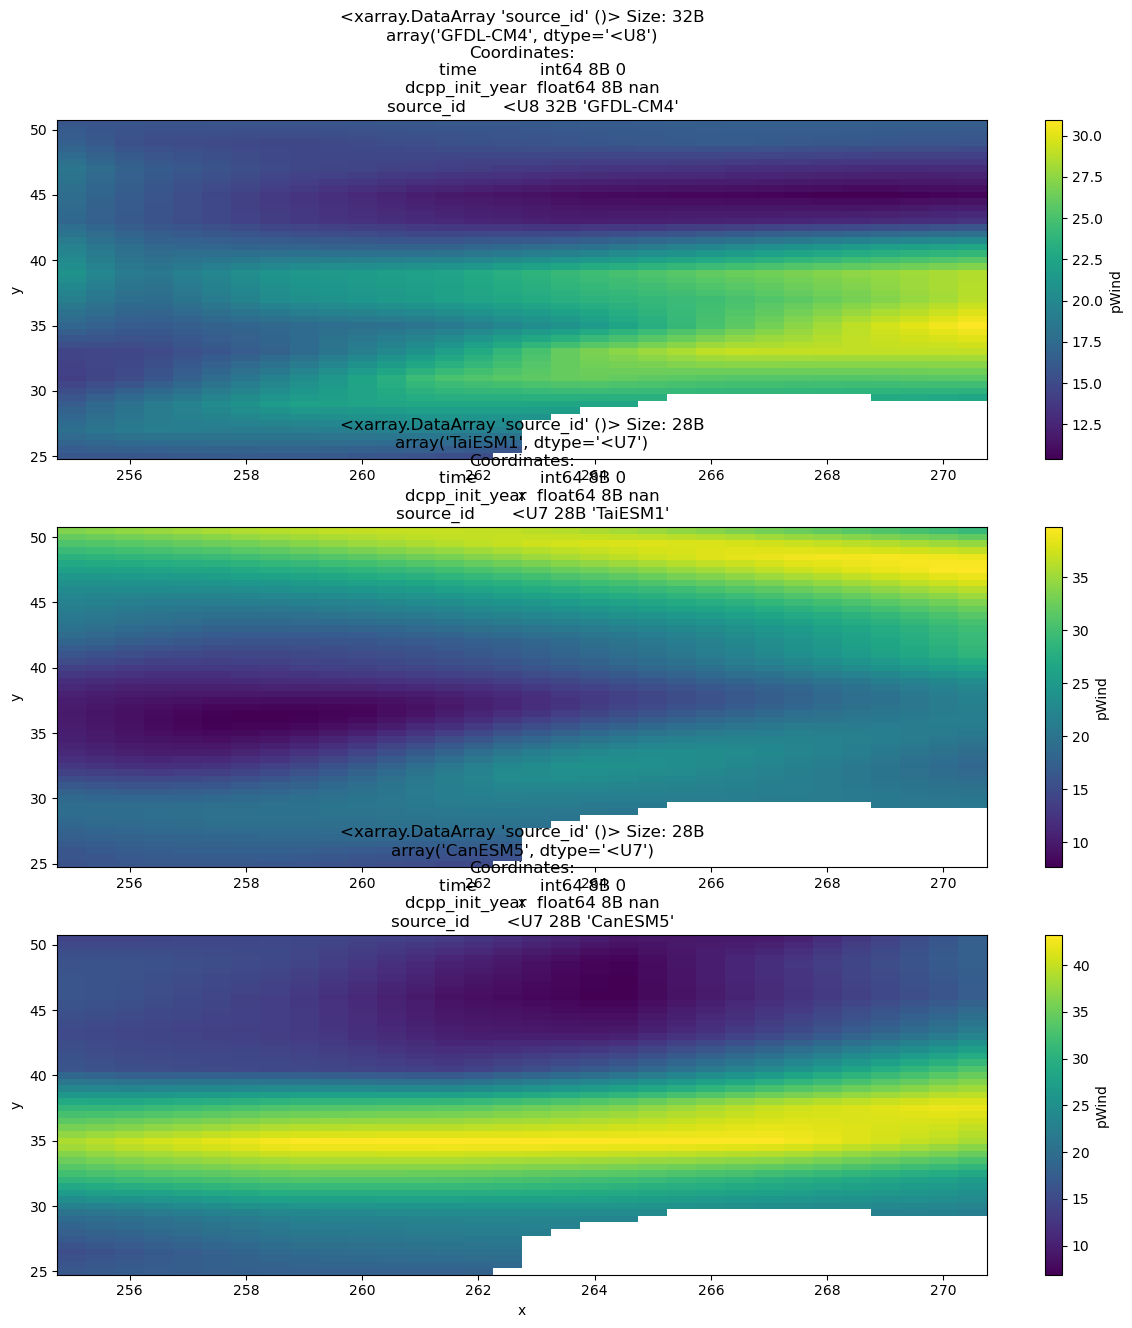

In [84]:
fig, axarr = plt.subplots(nrows=3, ncols=1, figsize=[15,15])

for key, ax in zip([0, 1, 2], axarr.flat):
    ds['pWind'].isel(source_id=key).isel(member_id = 0).isel(plev=3).plot(ax = ax)
    ax.set_title(ds.source_id.isel(source_id=key))

plt.savefig('../figures/test_map.png')
